In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")

In [20]:
cpath = 'data/map/cm_commune.json'
cm = gpd.read_file(cpath)

In [32]:
dpath = 'data/map/cm_district.json'
district = gpd.read_file(dpath)

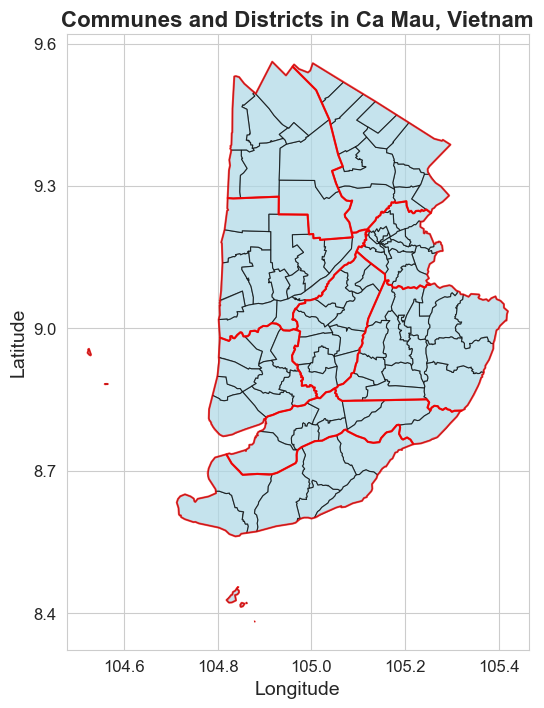

In [33]:
# Create a larger figure for better readability
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plotting communes with boundaries
cm.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.8, alpha=0.7)

# Plotting districts with boundaries
district.plot(ax=ax, color='none', edgecolor='red', linewidth=1.5, alpha=0.7)

# Enhancing the plot for publication quality
ax.set_title('Communes and Districts in Ca Mau, Vietnam', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))

# Show the plot
plt.show()

In [84]:
dt = pd.read_excel('data/dongthap.xlsx')

# Dropping unnecessary columns and rows that contain NaN values
dt = dt.dropna(axis=1, how='all')  # Drop columns with all NaN values
dt = dt.dropna(axis=0, how='all')  # Drop rows with all NaN values

# Renaming columns based on the actual data structure
# The number of column names should match the number of columns in the DataFrame
column_names = dt.columns[:len(dt.columns)]  # Adjusting to the correct number of columns
dt.columns = column_names

dt.columns = ['Code', 'Name', 'Level', 'Population']

In [80]:
dt

,Code,Name,Level,Population
0,866,Thành phố Cao Lãnh,Thành phố,NaN
1,867,Thành phố Sa Đéc,Thành phố,NaN
2,868,Thành phố Hồng Ngự,Thành phố,0.0
3,869,Huyện Tân Hồng,Huyện,NaN
4,870,Huyện Hồng Ngự,Huyện,NaN
5,871,Huyện Tam Nông,Huyện,NaN
6,872,Huyện Tháp Mười,Huyện,NaN
7,873,Huyện Cao Lãnh,Huyện,NaN
8,874,Huyện Thanh Bình,Huyện,NaN
9,875,Huyện Lấp Vò,Huyện,NaN


In [85]:
district

,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,VNM.18.2_1,VNM,Vietnam,VNM.18_1,ĐồngTháp,NA,CaoLãnh,CaoLanh,NA,Huyện,District,NA,VN.TB.DH,"MULTIPOLYGON (((105.81910 10.34340, 105.81890 ..."
1,VNM.18.1_1,VNM,Vietnam,VNM.18_1,ĐồngTháp,NA,CaoLãnh(Thànhphố),CaoLanh,NA,Thànhphố,City,NA,VN.TY.DY,"MULTIPOLYGON (((105.68500 10.43900, 105.69130 ..."
2,VNM.18.3_1,VNM,Vietnam,VNM.18_1,ĐồngTháp,NA,ChâuThành,ChauThanh,NA,Huyện,District,NA,VN.BP.DP,"MULTIPOLYGON (((105.83250 10.14970, 105.81850 ..."
3,VNM.18.5_1,VNM,Vietnam,VNM.18_1,ĐồngTháp,NA,HồngNgự,HongNgu,NA,Huyện,District,NA,VN.TH.DS,"MULTIPOLYGON (((105.30290 10.71640, 105.29470 ..."
4,VNM.18.4_1,VNM,Vietnam,VNM.18_1,ĐồngTháp,NA,HồngNgự(Thịxã),HongNgu,NA,Thịxã,Town,NA,VN.QN.DT,"MULTIPOLYGON (((105.38820 10.76560, 105.36850 ..."
5,VNM.18.7_1,VNM,Vietnam,VNM.18_1,ĐồngTháp,NA,LaiVung,LaiVung,NA,Huyện,District,NA,VN.HG.DV,"MULTIPOLYGON (((105.64630 10.16680, 105.62490 ..."
6,VNM.18.6_1,VNM,Vietnam,VNM.18_1,ĐồngTháp,NA,LấpVò,LapVo,NA,Huyện,District,NA,VN.BP.DX,"MULTIPOLYGON (((105.49540 10.32530, 105.48770 ..."
7,VNM.18.8_1,VNM,Vietnam,VNM.18_1,ĐồngTháp,NA,SaĐéc,SaDec,NA,Thànhphố,City,NA,VN.PY.DX,"MULTIPOLYGON (((105.76910 10.30570, 105.77590 ..."
8,VNM.18.9_1,VNM,Vietnam,VNM.18_1,ĐồngTháp,NA,TamNông,TamNong,NA,Huyện,District,NA,VN.GL.DC,"MULTIPOLYGON (((105.49600 10.66340, 105.46950 ..."
9,VNM.18.10_1,VNM,Vietnam,VNM.18_1,ĐồngTháp,NA,TânHồng,TanHong,NA,Huyện,District,NA,VN.LA.DO,"MULTIPOLYGON (((105.42320 10.83020, 105.41840 ..."


In [87]:
dt['Name'] = dt['Name'].str.replace('Huyện ', '').str.replace('Thành phố ', '')

In [89]:
dt['Name'] = dt['Name'].str.replace(' ', '')

In [90]:
dt

,Code,Name,Level,Population
0,866,CaoLãnh,Thành phố,NaN
1,867,SaĐéc,Thành phố,NaN
2,868,HồngNgự,Thành phố,0.0
3,869,TânHồng,Huyện,NaN
4,870,HồngNgự,Huyện,NaN
5,871,TamNông,Huyện,NaN
6,872,ThápMười,Huyện,NaN
7,873,CaoLãnh,Huyện,NaN
8,874,ThanhBình,Huyện,NaN
9,875,LấpVò,Huyện,NaN
